In [13]:
import os

# data
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# sklearn
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import preprocessing
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, LeavePOut, LeaveOneOut, \
    ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, GroupKFold, \
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator


import warnings
warnings.filterwarnings("ignore")

### Functions

#### Mean absolute percentage error

In [2]:
def mape_scorer(estimator, X_test, y_test):
    return -mape(np.exp(y_test), np.exp(estimator.predict(X_test)))

In [3]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Инфа о таблице

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

#### Кросс валидация модели

In [4]:
def check_error(train_df, model, n_splits=10, target_func=mean_absolute_error):
    assert train_df.isna().sum().sum() == 0, \
        f'Есть пропущенные значения! Количество:\n{train_df.isna().sum().replace(0, pd.np.nan).dropna(axis=0)}'
    
    y_train = train_df.SalePrice.values
    X_train = train_df.drop(columns=['SalePrice']).values

    rs = ShuffleSplit(n_splits=n_splits, test_size=.25, random_state=0)
    scores = []
    for train_index, valid_index in rs.split(X_train):
        model.fit(X=X_train[train_index], y=y_train[train_index])
        prediction = model.predict(X_train[valid_index])
        scores.append(target_func(prediction, y_train[valid_index]))
    scores = np.array(scores)
    print(f'{model.__class__.__name__} // {target_func.__name__} : {scores.mean()}')
    return scores.mean()

### Load Data

In [257]:
os.getcwd()

'C:\\Users\\altuhov.n.a\\PycharmProjects\\ML\\kaggle_competitions\\house_price_prediction'

In [4]:
train_df = pd.read_csv(r'input/train.csv')
test_df = pd.read_csv(r'input/test.csv')
sample_submission_df = pd.read_csv(r'input/sample_submission.csv') # Пример предсказания

print(f'Train: {train_df.shape}; Test: {test_df.shape}')

Train: (1460, 81); Test: (1459, 80)


In [273]:
sample_submission_df.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


### Предобработка

#### Убираем хвост у распределения целевой переменной

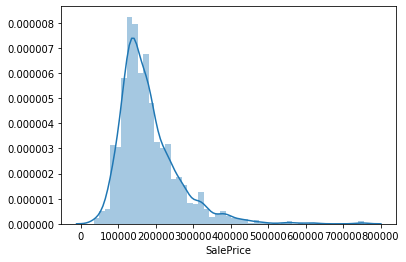

In [296]:
sns.distplot(train_df.SalePrice);

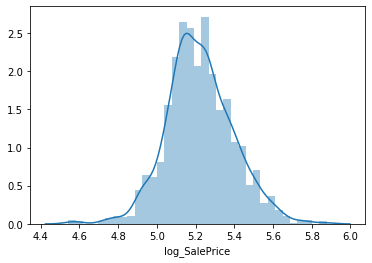

In [297]:
train_df['log_SalePrice'] = train_df.SalePrice.apply(np.log10)

sns.distplot(train_df.log_SalePrice);

#### Смотрим корреляцию между переменными, убираем коррелирующих

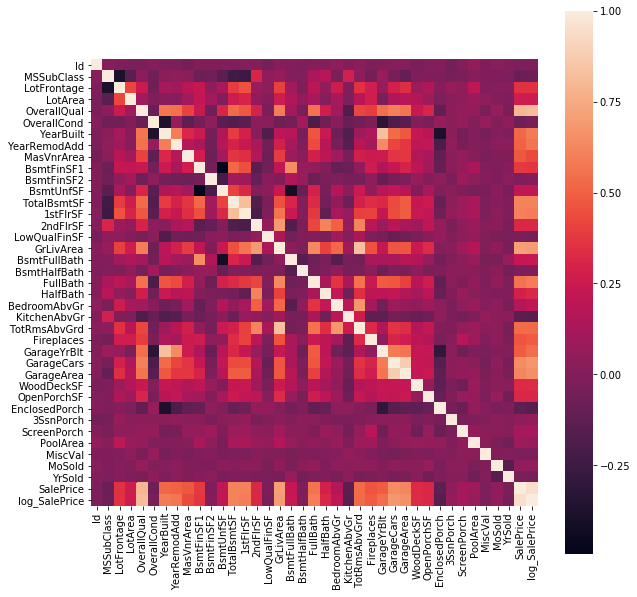

In [298]:
corr = train_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, cbar=True, annot=False, square=True, 
            fmt='.2f', annot_kws={'size': 8},
            yticklabels=corr.columns.values, xticklabels=corr.columns.values)

На основе тепловой карты видно, что пары переменных ('TotalBsmtSF', '1stFlrSF'), ('YearBuilt', 'GarageYrBlt'), ('GarageArea', 'GarageCars') сильно коррелируют. Убираем по одной из каждой пары. Убираем на основе предпочтений. 

In [299]:
resumetable(train_df[['TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'GarageYrBlt', 'GarageArea', 'GarageCars']])

Dataset Shape: (1460, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TotalBsmtSF,int64,0,721,856.0,1262.0,920.0,8.98
1,1stFlrSF,int64,0,753,856.0,1262.0,920.0,9.20
2,YearBuilt,int64,0,112,2003.0,1976.0,2001.0,6.27
3,GarageYrBlt,float64,81,97,2003.0,1976.0,2001.0,6.10
4,GarageArea,int64,0,441,548.0,460.0,608.0,7.75
5,GarageCars,int64,0,5,2.0,2.0,2.0,1.60


In [300]:
train_df = train_df.drop(columns=['GarageYrBlt', 'GarageCars', '1stFlrSF'])

#### Выводим информацию по всем переменным

In [301]:
resumetable(train_df)

Dataset Shape: (1460, 79)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Id,int64,0,1460,1,2,3,10.51
1,MSSubClass,int64,0,15,60,20,60,2.92
2,MSZoning,object,0,5,RL,RL,RL,1.00
3,LotFrontage,float64,259,110,65,80,68,5.77
4,LotArea,int64,0,1073,8450,9600,11250,9.70
5,Street,object,0,2,Pave,Pave,Pave,0.04
6,Alley,object,1369,2,NaN,NaN,NaN,0.99
7,LotShape,object,0,4,Reg,Reg,IR1,1.14
8,LandContour,object,0,4,Lvl,Lvl,Lvl,0.63
9,Utilities,object,0,2,AllPub,AllPub,AllPub,0.01


#### Удаляю колонки с большим количеством пропущенных значений

In [302]:
mis_perc = 0.95
columns_for_delete = [col for col in train_df.columns if train_df[col].isna().sum() > len(train_df) * mis_perc]
if columns_for_delete:
    print(f'Удаляю колонки {columns_for_delete} так как в них больше {int(mis_perc * 100)}% пропущенных значений')
    train_df = train_df.drop(columns=columns_for_delete)
else:
    print(f'Нет колонок где больше {int(mis_perc * 100)}% пропущенных значений')

Удаляю колонки ['PoolQC', 'MiscFeature'] так как в них больше 95% пропущенных значений


#### Заполняем пропущенные значения

In [303]:
# Для категориальных величин берём моду, а для численных - медиану.
fill_empty = train_df.apply(lambda c: c.mode()[0] if c.dtype  == 'object' else c.median())
train_df = train_df.fillna(value=fill_empty)

#### Кодируем категориальные колонки через one_hot_encoding

Для OneHotEncoding задаём максимальное количество уникальных элементов.  
Все строковые колонки кодируем в числа через LabelEncoding, а прошедшие порог в OneHotEncoding. 

In [313]:
max_ohe_nunique = 10
train_df = train_df.set_index('Id')

str_columns = train_df.columns[train_df.dtypes == 'object']
num_columns = list(set(train_df.columns) - set(str_columns))
print(f'Числовых колонок: {len(num_columns)}')
print(f'Строковых колонок: {len(str_columns)}')
cat_columns = [col for col in str_columns if train_df[col].nunique() < max_ohe_nunique]
notcat_columns = list(set(str_columns) - set(cat_columns))
print(f'НЕкатегориальных колонок: {len(notcat_columns)}')
print(f'Категориальныe колонки:')
resumetable(train_df[cat_columns])

Числовых колонок: 35
Строковых колонок: 41
НЕкатегориальных колонок: 3
Категориальныe колонки:
Dataset Shape: (1460, 38)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,MSZoning,object,0,5,RL,RL,RL,1.00
1,Street,object,0,2,Pave,Pave,Pave,0.04
2,Alley,object,0,2,Grvl,Grvl,Grvl,0.18
3,LotShape,object,0,4,Reg,Reg,IR1,1.14
4,LandContour,object,0,4,Lvl,Lvl,Lvl,0.63
5,Utilities,object,0,2,AllPub,AllPub,AllPub,0.01
6,LotConfig,object,0,5,Inside,FR2,Inside,1.22
7,LandSlope,object,0,3,Gtl,Gtl,Gtl,0.34
8,Condition1,object,0,9,Norm,Feedr,Norm,0.90
9,Condition2,object,0,8,Norm,Norm,Norm,0.11


In [314]:
# LabelEncoding noncategorical columns
train_df[notcat_columns] = train_df[notcat_columns].apply(LabelEncoder().fit_transform)

# OneHotEncoding categorical columns
ohe = OneHotEncoder(handle_unknown='ignore')
encoded = pd.DataFrame(ohe.fit_transform(train_df[cat_columns]).toarray(), index=train_df.index)
train_df = pd.concat([train_df[num_columns + notcat_columns], encoded], axis=1)

### Тестим разные модельки

In [344]:
# RandomForestRegressor
check_error(train_df, model=RandomForestRegressor(n_estimators=150), 
            n_splits=10, target_func=mean_absolute_percentage_error)

RandomForestRegressor // mean_absolute_percentage_error : 0.3734548643423642


0.3734548643423642

In [345]:
# LineralRegression
check_error(train_df, model=LinearRegression(), 
            n_splits=10, target_func=mean_absolute_percentage_error)

LinearRegression // mean_absolute_percentage_error : 17.328411801920552


17.328411801920552

In [353]:
# LineralRegression with L2 lineralization
check_error(train_df, model=Ridge(alpha=50), 
            n_splits=10, target_func=mean_absolute_percentage_error)

Ridge // mean_absolute_percentage_error : 10.798373358763632


10.798373358763632

In [359]:
# LineralRegression with L1 lineralization
check_error(train_df, model=Lasso(alpha=200), 
            n_splits=10, target_func=mean_absolute_percentage_error)

Lasso // mean_absolute_percentage_error : 10.736277571062079


10.736277571062079

### Тоже самое, только с использованием Pipeline

#### MyTransformer

Удаление колонок с большим количеством пропусков, заполнение пропусков, кодирование строковых через LabelEncoding, а категориальных через OneHotEncoding 

In [5]:
class MyTransformer(TransformerMixin, BaseEstimator):
    
    def __init__(self, index_column='Id', null_threshold=0.9, max_ohe_nunique=10):
        self.null_threshold = null_threshold
        self.max_ohe_nunique = max_ohe_nunique
        self.columns_for_delete = []
        self.index_column = index_column

    
    def transform(self, X, y=None):
        df = X.set_index(self.index_column)
        
        # Удаляем колонки с большим количеством пропусков
        df = df.drop(columns=self.columns_for_delete)
        
        # Заполняем пропущенные значения
        # Для категориальных величин берём моду, а для численных - медиану.
        df = df.fillna(value=self.fill_empty)
        # Кодируем через LabelEncoder строковые некaтегориaльные колонки 
        for col, enc in self.label_encoder_dict.items():
            df[col] = enc.transform(df[col])
        
        # Кодируем с посмощью OneHotEncoder категориальные колонки
        encoded = self.ohe.transform(df[self.cat_columns])
        encoded = pd.DataFrame(encoded.toarray(), index=df.index)
        
         # Удаляем колонки, состоящие только из нулей и только из единиц
#         encoded = encoded.drop(encoded.loc[:, encoded.sum() == 0], axis=1)
#         encoded = encoded.drop(encoded.loc[:, encoded.sum() == len(encoded)], axis=1)
        
        # Объединяем в большой датафрейм
        df = pd.concat([df[self.num_columns + self.notcat_columns], encoded], axis=1)
        
        return df        
    
    
    def fit(self, X, y=None):
        df = X.set_index(self.index_column)

        # Удаляем колонки с большим количеством пропусков
        self.columns_for_delete = [col for col in df.columns if df[col].isna().sum() > len(df) * self.null_threshold]
#         if self.columns_for_delete:
#             print(f'Удаляю колонки {self.columns_for_delete} так как в них больше ' \
#                   f'{int(self.null_threshold * 100)}% пропущенных значений')
#         else:
#             print(f'Нет колонок где больше {int(self.null_threshold * 100)}% пропущенных значений')
        # Заполняем пропущенные значения
        # Для категориальных величин берём моду, а для численных - медиану.
        self.fill_empty = df.apply(lambda c: c.mode()[0] if c.dtype  == 'object' else c.median())
        
        # Кодируем категориальные колонки через one_hot_encoding
        self.active_columns = list(set(df.columns) - set(self.columns_for_delete))
        self.str_columns = [col for col in self.active_columns if df[col].dtype == 'object']
        self.num_columns = list(set(self.active_columns) - set(self.str_columns))
        self.cat_columns = [col for col in self.str_columns if df[col].nunique() < self.max_ohe_nunique]
        self.notcat_columns = list(set(self.str_columns) - set(self.cat_columns))
#         print(f'Числовых колонок: {len(self.num_columns)}')
#         print(f'Строковых колонок: {len(self.str_columns)}')
#         print(f'НЕкатегориальных колонок: {len(self.notcat_columns)}')
#         print(f'Категориальныx колонoк: {len(self.cat_columns)}')
        
        # Кодируем через LabelEncoder строковые некотегориaльные колонки 
        self.label_encoder_dict = {col: LabelEncoder().fit(unique_columns_values[col]) for col in self.notcat_columns}
        
        # Кодируем с посмощью OneHotEncoder категориальные колонки
        self.ohe = OneHotEncoder(handle_unknown='ignore')
        self.ohe.fit(df[self.cat_columns].fillna('0'))
        
        return self

#### MyScaler

In [6]:
class MyScaler(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.scaler = StandardScaler()
    
    def transform(self, X, y=None):
        X = X.copy()
        X[self.float_columns] = self.scaler.transform(X[self.float_columns])
        return X
    
    def fit(self, X, y=None):
        self.float_columns = X.columns[X.dtypes == 'float']
        self.scaler.fit(X[self.float_columns])
        return self
        

#### Поиск лучшего сочетания параметров 

In [7]:
X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df.set_index('Id').SalePrice
X_test = test_df
full_df = pd.concat([X_train, X_test], axis=0)
unique_columns_values = {col: full_df[col].dropna().unique() for col in full_df.columns}

In [8]:
pipe = Pipeline(steps=[
    ('process', MyTransformer(index_column='Id', null_threshold=0.05)),
    ('scale', MyScaler()),
    ('reg', LinearRegression())
])

In [31]:
params = [
    {
        'process__null_threshold': [0, 0.05],
        'reg': [Lasso()],
        'reg__alpha': [0.001]
    },
    {
        'process__null_threshold': [0.05],
        'reg': [ElasticNet()],
        'reg__alpha': [0.0562],
        'reg__l1_ratio': [0.03162]
    }
]


In [32]:
train_idxs, valid_idxs = X_train.loc[X_train.YrSold < 2010].index, X_train.loc[X_train.YrSold == 2010].index
grid_search = GridSearchCV(pipe, params, cv=[[train_idxs, valid_idxs]], scoring=mape_scorer)
grid_search.fit(X_train, np.log(y_train));

print(f'Best: {grid_search.best_params_["reg"].__class__.__name__} (MAPE {abs(grid_search.best_score_)})')      

Best: ElasticNet (MAPE 8.73625597535244)


#### Анализ получившихся моделей

In [33]:
cv_grid = pd.DataFrame(grid_search.cv_results_['params'])
cv_grid['val MAPE'] = -grid_search.cv_results_['mean_test_score']
cv_grid['reg__alpha'] = cv_grid['reg__alpha'].fillna('0.')
cv_grid['reg__l1_ratio'] = cv_grid['reg__l1_ratio'].fillna('0.')
cv_grid['reg'] = cv_grid['reg'].apply(lambda x: x.__class__.__name__)

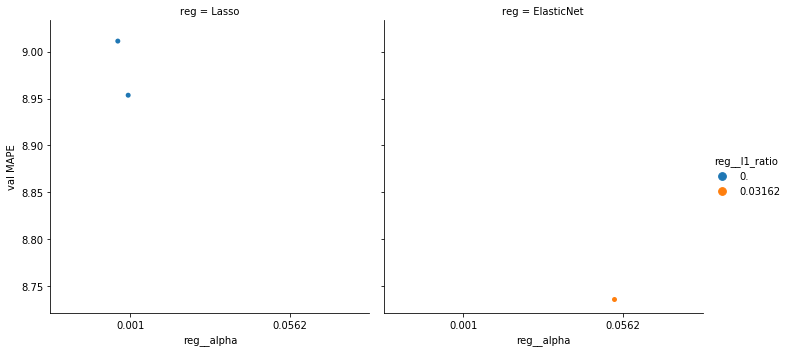

In [34]:
sns.catplot(x='reg__alpha', y='val MAPE', hue='reg__l1_ratio', col='reg', data=cv_grid)

In [35]:
grid_search.best_params_

{'process__null_threshold': 0.05,
 'reg': ElasticNet(alpha=0.0562, copy_X=True, fit_intercept=True, l1_ratio=0.03162,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'reg__alpha': 0.0562,
 'reg__l1_ratio': 0.03162}

#### Формирование файла с предсказанием по тестовой выборке

In [36]:
test_prediction_df = pd.DataFrame(np.exp(grid_search.predict(X_test)), index=X_test.Id, columns=['SalePrice'])

In [37]:
test_prediction_df.to_csv('output/submission.csv')